In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from shapely import wkt
import os

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
data_dir = '../data'
health = pd.read_csv(os.path.join(data_dir, 'health.csv'), index_col=0)
health.shape

(125, 31)

In [3]:
#Function to display at most 1000 rows and at most 1000 columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
display_all(health.head())

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,geometry,num_hospitals_rhus,num_occupied_beds,num_vacant_beds,num_staff_quarantined,num_staff_admitted,occupied_ventilators,vacant_ventilators,num_covid_cases,RECOVERED,ASYMPTOMATIC,MILD,MODERATE,SEVERE,CRITICAL,DIED,Total_under18,Total_18to59,Total_over60,Male_under18,Male_18to59,Male_over60,Female_under18,Female_18to59,Female_over60
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH153600000,LANAO DEL SUR,PH153630000,WAO,"POLYGON ((124.8205116800001 7.536284726000074,...",2,0,0,0,0,0,0,34,34,0,0,0,0,0,0,19102.0,23712.0,3048.0,9736.0,12343.0,1462.0,9366.0,11369.0,1586.0
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH156600000,SULU,PH156619000,OMAR,MULTIPOLYGON (((121.3806300530001 5.9276100470...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12633.0,11870.0,613.0,6235.0,5824.0,322.0,6398.0,6046.0,291.0
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH156600000,SULU,PH156609000,PARANG,MULTIPOLYGON (((120.881530762 6.01489257900004...,4,1,1,1,1,1,1,4,4,0,0,0,0,0,0,32044.0,28605.0,1523.0,15297.0,13964.0,783.0,16747.0,14641.0,740.0
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH153800000,MAGUINDANAO,PH153807000,DATU ODIN SINSUAT (DINAIG),"POLYGON ((124.296694397 6.989300519000039, 124...",3,2,2,2,2,2,2,185,179,0,2,0,0,0,4,42507.0,53127.0,3576.0,21480.0,26056.0,1818.0,21027.0,27071.0,1758.0
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH153600000,LANAO DEL SUR,PH153621000,PIAGAPO,"POLYGON ((124.108844307 7.951962018000073, 124...",1,0,0,0,0,0,0,7,7,0,0,0,0,0,0,13218.0,11677.0,545.0,6658.0,5723.0,321.0,6560.0,5954.0,224.0


In [5]:
health.dtypes

Reg_Code                  object
Reg_Name                  object
Pro_Code                  object
Pro_Name                  object
Mun_Code                  object
Mun_Name                  object
geometry                  object
num_hospitals_rhus         int64
num_occupied_beds          int64
num_vacant_beds            int64
num_staff_quarantined      int64
num_staff_admitted         int64
occupied_ventilators       int64
vacant_ventilators         int64
num_covid_cases            int64
RECOVERED                  int64
ASYMPTOMATIC               int64
MILD                       int64
MODERATE                   int64
SEVERE                     int64
CRITICAL                   int64
DIED                       int64
Total_under18            float64
Total_18to59             float64
Total_over60             float64
Male_under18             float64
Male_18to59              float64
Male_over60              float64
Female_under18           float64
Female_18to59            float64
Female_ove

In [6]:
# Change df to geodataframe
health['geometry'] = health['geometry'].apply(wkt.loads)
health = gpd.GeoDataFrame(health, geometry='geometry')

In [7]:
# Add the centroid of each city / municipality
health['centroid'] = health['geometry'].centroid
health['lon'] = health['centroid'].x
health['lat'] = health['centroid'].y
display_all(health.head())

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,geometry,num_hospitals_rhus,num_occupied_beds,num_vacant_beds,num_staff_quarantined,num_staff_admitted,occupied_ventilators,vacant_ventilators,num_covid_cases,RECOVERED,ASYMPTOMATIC,MILD,MODERATE,SEVERE,CRITICAL,DIED,Total_under18,Total_18to59,Total_over60,Male_under18,Male_18to59,Male_over60,Female_under18,Female_18to59,Female_over60,centroid,lon,lat
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH153600000,LANAO DEL SUR,PH153630000,WAO,"POLYGON ((124.82051 7.53628, 124.82037 7.53616...",2,0,0,0,0,0,0,34,34,0,0,0,0,0,0,19102.0,23712.0,3048.0,9736.0,12343.0,1462.0,9366.0,11369.0,1586.0,POINT (124.70638 7.64668),124.706376,7.646684
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH156600000,SULU,PH156619000,OMAR,"MULTIPOLYGON (((121.38063 5.92761, 121.38063 5...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12633.0,11870.0,613.0,6235.0,5824.0,322.0,6398.0,6046.0,291.0,POINT (121.39331 5.98858),121.393306,5.988578
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH156600000,SULU,PH156609000,PARANG,"MULTIPOLYGON (((120.88153 6.01489, 120.88092 6...",4,1,1,1,1,1,1,4,4,0,0,0,0,0,0,32044.0,28605.0,1523.0,15297.0,13964.0,783.0,16747.0,14641.0,740.0,POINT (120.92139 5.93564),120.921388,5.935641
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH153800000,MAGUINDANAO,PH153807000,DATU ODIN SINSUAT (DINAIG),"POLYGON ((124.29669 6.98930, 124.26466 6.98042...",3,2,2,2,2,2,2,185,179,0,2,0,0,0,4,42507.0,53127.0,3576.0,21480.0,26056.0,1818.0,21027.0,27071.0,1758.0,POINT (124.23581 7.09471),124.235809,7.094712
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH153600000,LANAO DEL SUR,PH153621000,PIAGAPO,"POLYGON ((124.10884 7.95196, 124.10220 7.95666...",1,0,0,0,0,0,0,7,7,0,0,0,0,0,0,13218.0,11677.0,545.0,6658.0,5723.0,321.0,6560.0,5954.0,224.0,POINT (124.16664 7.99189),124.166645,7.991893


# Modeling

## K-means clustering using number of covid cases only as weights

In [8]:
# Parameters
k = 10
n_init = 10
max_iter = 100

X = list(zip(health['lon'], health['lat']))
weights = health['num_covid_cases']

kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, 
                random_state=18).fit(X, sample_weight=weights)

In [9]:
# Predicted facility locations based on centers
kmeans.cluster_centers_

array([[124.46691013,   7.73417428],
       [120.99149509,   6.03143746],
       [119.84490029,   5.08477399],
       [124.81183337,   7.07960581],
       [122.06625287,   6.59316124],
       [118.30510701,   6.44259369],
       [124.2698361 ,   7.98069312],
       [124.41930609,   6.9944107 ],
       [124.24717645,   7.23458077],
       [119.44573841,   4.76769907]])

In [10]:
# Sum of squared distances of data points to their closest cluster center
kmeans.inertia_

72.99632495595905

In [11]:
# Predicted cluster center for each data point
kmeans.labels_

array([0, 1, 1, 8, 6, 4, 7, 9, 7, 6, 7, 0, 0, 1, 4, 1, 3, 7, 6, 4, 1, 8,
       6, 2, 8, 1, 7, 3, 2, 6, 8, 6, 1, 7, 1, 6, 8, 3, 4, 4, 1, 1, 0, 6,
       7, 3, 5, 1, 7, 1, 0, 5, 3, 8, 6, 7, 0, 7, 6, 4, 8, 3, 6, 2, 3, 6,
       6, 1, 4, 9, 6, 6, 2, 1, 7, 1, 0, 7, 0, 4, 6, 8, 4, 6, 6, 7, 6, 7,
       0, 3, 6, 2, 8, 2, 2, 0, 8, 0, 6, 4, 4, 6, 6, 3, 8, 7, 4, 1, 7, 0,
       7, 3, 7, 0, 4, 1, 6, 1, 8, 3, 7, 7, 7, 6, 6])

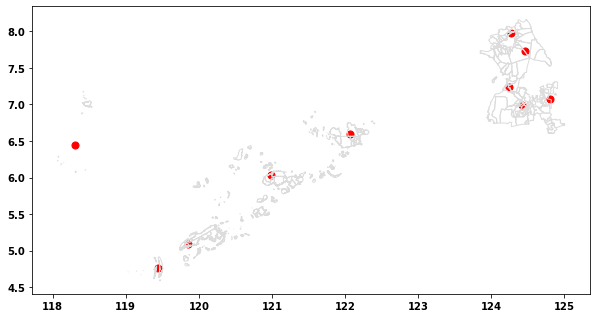

In [12]:
lon = [center[0] for center in kmeans.cluster_centers_]
lat = [center[1] for center in kmeans.cluster_centers_]
cluster_centers = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon, lat))

# Visualizing cluster centers
ax = health['geometry'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)
cluster_centers.plot(figsize=(10,10), color='r', markersize=50, ax=ax)
plt.show()

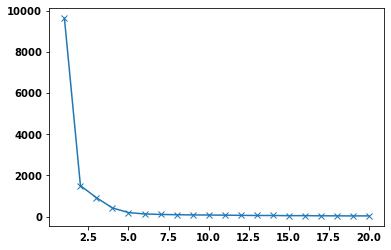

In [13]:
# Elbow method to find ideal k

# Parameters
n_init = 10
max_iter = 100

X = list(zip(health['lon'], health['lat']))
weights = health['num_covid_cases']

inertias = []
for k in range(1,21):
    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, 
                random_state=18).fit(X, sample_weight=weights)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(1,21), inertias, 'x-')
plt.show()

# Elbow somewhere before 2.5?

In [15]:
# Silhouette score to find ideal k
for k in range(2,21):
    labels = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, 
                random_state=18).fit_predict(X, sample_weight=weights)
    avg = silhouette_score(X, labels)
    print("For k=%d, the score is %g"%(k,avg))
    
# The closer 1 the silhouette score is, the better
# Thus, ideal k = 2

For k=2, the score is 0.768539
For k=3, the score is 0.727782
For k=4, the score is 0.571328
For k=5, the score is 0.582346
For k=6, the score is 0.503793
For k=7, the score is 0.525734
For k=8, the score is 0.443568
For k=9, the score is 0.480706
For k=10, the score is 0.408996
For k=11, the score is 0.363953
For k=12, the score is 0.435464
For k=13, the score is 0.40338
For k=14, the score is 0.397863
For k=15, the score is 0.428444
For k=16, the score is 0.399773
For k=17, the score is 0.426912
For k=18, the score is 0.381787
For k=19, the score is 0.410302
For k=20, the score is 0.386155


## K-means clustering using multiple features

1. Scale features
2. Reduce dimensions of features into 1 using PCA
3. Use PCA-reduced 1D feature weight for K-means clustering

In [16]:
feat = ['num_hospitals_rhus', 'num_occupied_beds', 'num_vacant_beds',
       'num_staff_quarantined', 'num_staff_admitted', 
       'occupied_ventilators', 'vacant_ventilators',
       'num_covid_cases','RECOVERED', 'ASYMPTOMATIC', 'MILD', 'MODERATE', 'SEVERE', 'CRITICAL', 'DIED',
       'Total_under18', 'Total_18to59', 'Total_over60']

In [17]:
health_feat = health[feat]
health_feat.shape

(125, 18)

In [18]:
health_feat.head()

,num_hospitals_rhus,num_occupied_beds,num_vacant_beds,num_staff_quarantined,num_staff_admitted,occupied_ventilators,vacant_ventilators,num_covid_cases,RECOVERED,ASYMPTOMATIC,MILD,MODERATE,SEVERE,CRITICAL,DIED,Total_under18,Total_18to59,Total_over60
0,2,0,0,0,0,0,0,34,34,0,0,0,0,0,0,19102.0,23712.0,3048.0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12633.0,11870.0,613.0
2,4,1,1,1,1,1,1,4,4,0,0,0,0,0,0,32044.0,28605.0,1523.0
3,3,2,2,2,2,2,2,185,179,0,2,0,0,0,4,42507.0,53127.0,3576.0
4,1,0,0,0,0,0,0,7,7,0,0,0,0,0,0,13218.0,11677.0,545.0


In [19]:
# Scale features before PCA
scaled_health_feat = scale(health_feat)

In [20]:
scaled_health_feat

array([[ 0.5276677 , -0.36555364, -0.36555364, ...,  0.2905497 ,
         0.66499302,  2.42712429],
       [-0.28663431, -0.36555364, -0.36555364, ..., -0.23207924,
        -0.23594916, -0.35640097],
       [ 2.15627172,  0.83692544,  0.83692544, ...,  1.33613074,
         1.03725362,  0.68384871],
       ...,
       [-0.28663431, -0.36555364, -0.36555364, ..., -0.21196259,
        -0.37304575, -0.25466227],
       [-0.28663431, -0.36555364, -0.36555364, ...,  0.12953571,
         0.12931206, -0.28438369],
       [-0.28663431, -0.36555364, -0.36555364, ..., -0.50757232,
        -0.64206548, -0.70048356]])

In [21]:
# PCA dimension reduction of features into 1D weight
pca = PCA(n_components=1).fit(scaled_health_feat)
weights = pca.transform(scaled_health_feat)

In [22]:
np.shape(weights)

(125, 1)

In [23]:
np.concatenate(weights)

array([-0.49398926, -1.19313155,  1.69304684,  5.58236391, -1.16783995,
       -0.50291752, -1.12709619, -0.54819032, -1.26448215,  1.47624993,
       -1.22077396, -1.36323797, -1.04240613, -1.09673411, -1.22165594,
       -0.55368435, -1.06370481, -0.98679422, -1.14775577, -1.06088616,
        1.30097725, -1.19036851, -1.06831819, -0.93195773, -1.1717928 ,
       -1.16737208, -1.02855138, 11.42313275, -0.88484406, -0.98277028,
       -0.99311497,  9.70948742,  6.39927916,  1.03122875, -1.22861431,
       -1.263418  ,  3.53574347, -1.16668826,  6.43918992, -0.997647  ,
       -0.9477996 , -1.22807091, -0.92750419, -1.07989259, -1.25730889,
       -1.12418272, -0.99933898, -1.48112901, -1.16208222,  0.75774552,
       -0.97824022, -1.47514052, -0.86028102, -1.06051713, -0.72128221,
        1.2522118 , -1.08291134,  9.04781987, -1.01292799, -1.21651492,
       -1.14758611, -0.72886563, -1.11199392, -1.0064135 ,  1.07209389,
       -1.21117393,  0.05995131, -1.14624121, -1.14552773,  1.39

In [24]:
# Parameters
k = 10
n_init = 10
max_iter = 100

X = list(zip(health['lon'], health['lat']))

kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, 
                random_state=18).fit(X, sample_weight=np.concatenate(weights))

C:\Users\ROSIEL\anaconda3\lib\site-packages\ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  if __name__ == '__main__':


In [25]:
# Predicted facility locations based on centers
print(kmeans.cluster_centers_)

# Sum of squared distances of data points to their closest cluster center
print(kmeans.inertia_)

# Predicted cluster center for each data point
print(kmeans.labels_)

[[127.98651921   6.82945464]
 [125.24141526   7.21778078]
 [124.75120051   7.64538387]
 [127.49756891   6.25201913]
 [123.90364358   7.12206882]
 [124.85707147   7.10420596]
 [124.68045663   7.23689384]
 [124.91009379   7.90184745]
 [119.31984215   5.40613628]
 [117.77796684  -0.28581783]]
-42.46045293890573
[2 8 8 4 2 4 5 8 6 2 6 2 2 8 4 8 5 5 2 4 8 4 2 8 4 8 6 5 8 2 4 2 8 6 8 2 6
 5 4 4 8 8 2 4 6 6 8 8 6 8 2 8 5 6 2 6 2 6 2 4 4 5 2 8 6 2 2 8 4 8 4 2 8 8
 4 8 2 4 2 4 2 4 4 2 7 6 7 6 2 5 4 8 4 8 8 2 6 2 2 4 4 2 4 5 4 6 4 8 6 2 6
 5 6 2 4 8 2 8 4 5 6 6 6 2 2]


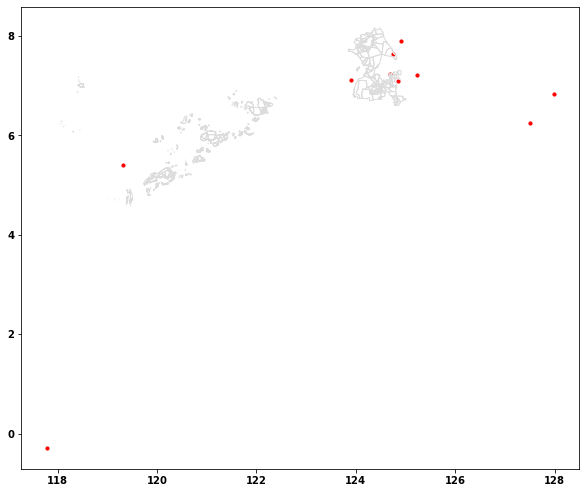

In [26]:
lon = [center[0] for center in kmeans.cluster_centers_]
lat = [center[1] for center in kmeans.cluster_centers_]
cluster_centers = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon, lat))

# Visualizing cluster centers
ax = health['geometry'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)
cluster_centers.plot(figsize=(10,10), color='r', markersize=10, ax=ax)
plt.show()

# To-do next
1. Predict only within land-connected island & do k-means clustering for each island
2. Include distance to nearest hospital / RHU as a feature (locations in `Hospitals_RHUs.csv`)
3. Use a clustering algorithm more suited for longitude & latitude (ex. DBSCAN)
- https://medium.com/@sylvainma/multi-feature-geo-clustering-with-dbscan-4857c6b932e2